In [50]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shutil

In [51]:
img_height = 432
img_width = 288

type_classification_directory = './data/img_data/dustan/phase1/mel_freq/'

type1_directory = './data/img_data/dustan/type1/mel_spectrogram/'

type2_directory = './data/img_data/dustan/type2/mel_spectrogram/'


In [52]:
def dummy(data,numarr):
    new_data =[]
    for i in data:
        lab_data = []
        for j in range(0,numarr):
            lab_data.append(0)
        #lab_data =[0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [53]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight 

In [54]:

def createdict(num):
    lab_data = []
    for i in range(0,num):
        lab_data.append(i)
    dic = dict.fromkeys(lab_data, 0)
    return dic

In [55]:
def createWeight(class_count,num_classes):
    class_weights = createdict(num_classes)
    for i in range(num_classes):
        class_weights[i]=create_weight(np.sum(class_count),num_classes,class_count[i])
    return class_weights

In [57]:
def preprocess(data_dir,numclass):
    data_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, labels='inferred', label_mode='int', image_size=(432, 288), seed=321,
    validation_split=None, subset=None)
    class_names = data_ds.class_names
    
    feature=[]
    label=[]
    for images, labels in data_ds.unbatch().take(-1):
        feature.append(images.numpy())
        label.append(labels.numpy())
        
    x_train,x_test,y_train,y_test = train_test_split(feature,label,test_size = 0.20,random_state =101)
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    
    class_count=[]
    for i in range(0,numclass):
        class_count.append(np.count_nonzero(y_train == i))
    class_count = np.array(class_count)
    y_train = dummy(y_train,numclass)
    y_test = dummy(y_test,numclass)
    class_weights = createWeight(class_count,numclass)
   
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return x_train,x_test,y_train,y_test,class_weights,class_names
    

In [58]:
x_train,x_test,y_train,y_test,class_weights,class_names = preprocess(type_classification_directory,2)

Found 175 files belonging to 2 classes.


In [59]:
def categories2binary(categories):
    binarydata = []
    for item in categories:
        binarydata.append(item[0])
    binarydata=np.array(binarydata)
    return(binarydata)

In [60]:
def binary2categories(binary):
    new_data = []
    for i in binary:
        lab_data = []
        for j in range(0,2):
            lab_data.append(0)
        if(i>=0.5):
            lab_data[1]=1;
        elif(i<0.5):
            lab_data[0]=1;
        new_data.append(lab_data)
    new_data = np.array(new_data)
    return(new_data)

In [61]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_6 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

In [62]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()



Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 19s 4s/step - loss: 7.0764 - accuracy: 0.5893 - val_loss: 1.2059 - val_accuracy: 0.6786
Epoch 2/100
4/4 [==============================] - 14s 4s/step - loss: 1.1527 - accuracy: 0.5268 - val_loss: 1.0232 - val_accuracy: 0.3214
Epoch 3/100
4/4 [==============================] - 14s 4s/step - loss: 0.8063 - accuracy: 0.3214 - val_loss: 0.7378 - val_accuracy: 0.3214
Epoch 4/100
4/4 [==============================] - 14s 4s/step - loss: 0.6694 - accuracy: 0.3214 - val_loss: 0.6985 - val_accuracy: 0.3214
Epoch 5/100
4/4 [==============================] - 14s 4s/step - loss: 0.6489 - accuracy: 0.3304 - val_loss: 0.6864 - val_accuracy: 0.3214
Epoch 6/100
4/4 [==============================] - 14s 4s/step - loss: 0.6308 - accuracy: 0.4107 - val_loss: 0.6825 - val_accuracy: 0.3214
Epoch 7/100
4/4 [==============================] - 14s 4s/step - loss: 0.6190 - accuracy: 0.4286 - val_loss: 0.6834 - val_accuracy: 0.3571
Epoch 8/100
4/4 [======================

[1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1]
              precision    recall  f1-score   support

       type1       0.71      0.45      0.56        11
       type2       0.79      0.92      0.85        24

    accuracy                           0.77        35
   macro avg       0.75      0.69      0.70        35
weighted avg       0.76      0.77      0.75        35



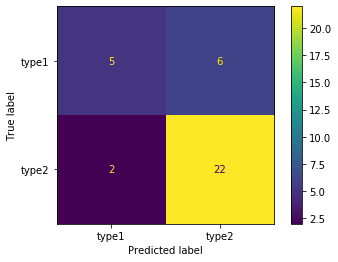

In [ ]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

In [ ]:
model.save('phase1.h5')

In [ ]:
x_train,x_test,y_train,y_test,class_weights,class_names = preprocess(type1_directory,2)

Found 175 files belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_4 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 20s 5s/step - loss: 5.4287 - accuracy: 0.4107 - val_loss: 1.0701 - val_accuracy: 0.3214
Epoch 2/100
4/4 [==============================] - 16s 4s/step - loss: 0.8982 - accuracy: 0.5625 - val_loss: 0.5791 - val_accuracy: 0.6786
Epoch 3/100
4/4 [==============================] - 13s 3s/step - loss: 0.8078 - accuracy: 0.6786 - val_loss: 0.5511 - val_accuracy: 0.6786
Epoch 4/100
4/4 [==============================] - 13s 3s/step - loss: 0.6774 - accuracy: 0.6786 - val_loss: 0.6239 - val_accuracy: 0.6786
Epoch 5/100
4/4 [==============================] - 13s 3s/step - loss: 0.6524 - accuracy: 0.6964 - val_loss: 0.6508 - val_accuracy: 0.7143
Epoch 6/100
4/4 [==============================] - 13s 3s/step - loss: 0.6554 - accuracy: 0.7589 - val_loss: 0.6384 - val_accuracy: 0.7143
Epoch 7/100
4/4 [==============================] - 14s 4s/step - loss: 0.6363 - accuracy: 0.7500 - val_loss: 0.5971 - val_accuracy: 0.7143
Epoch 8/100
4/4 [======================

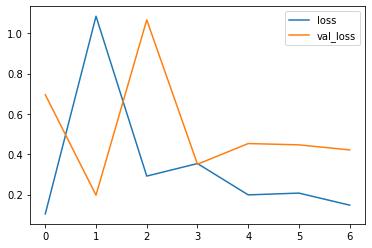

In [ ]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()


[1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0]
              precision    recall  f1-score   support

       type1       0.60      0.82      0.69        11
       type2       0.90      0.75      0.82        24

    accuracy                           0.77        35
   macro avg       0.75      0.78      0.76        35
weighted avg       0.81      0.77      0.78        35



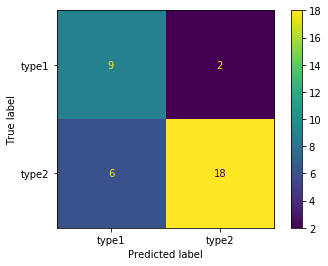

In [ ]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1) 
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

In [ ]:
model.save('type1.h5')

In [ ]:
x_train,x_test,y_train,y_test,class_weights,class_names = preprocess(type2_directory,3)

Found 175 files belonging to 2 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  


In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(3,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_5 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 19s 4s/step - loss: 4.2483 - accuracy: 0.5446 - val_loss: 0.4918 - val_accuracy: 0.7500
Epoch 2/100
4/4 [==============================] - 13s 3s/step - loss: 0.6753 - accuracy: 0.4107 - val_loss: 1.4877 - val_accuracy: 0.3214
Epoch 3/100
4/4 [==============================] - 13s 3s/step - loss: 0.6160 - accuracy: 0.3214 - val_loss: 0.7106 - val_accuracy: 0.4286
Epoch 4/100
4/4 [==============================] - 13s 3s/step - loss: 0.4196 - accuracy: 0.6429 - val_loss: 0.5599 - val_accuracy: 0.7500
Epoch 5/100
4/4 [==============================] - 13s 3s/step - loss: 0.4280 - accuracy: 0.7321 - val_loss: 0.5370 - val_accuracy: 0.7143
Epoch 6/100
4/4 [==============================] - 13s 3s/step - loss: 0.4078 - accuracy: 0.7321 - val_loss: 0.5277 - val_accuracy: 0.7500
Epoch 1/50
4/4 [==============================] - 48s 11s/step - loss: 0.4019 - binary_accuracy: 0.8163 - val_loss: 0.5022 - val_binary_accuracy: 0.8413
Epoch 2/50
4/4 [=========

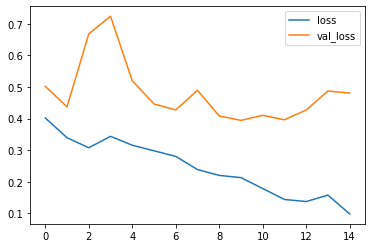

In [ ]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()


[1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1]
              precision    recall  f1-score   support

       type1       0.57      0.73      0.64        11
       type2       0.86      0.75      0.80        24

    accuracy                           0.74        35
   macro avg       0.71      0.74      0.72        35
weighted avg       0.77      0.74      0.75        35



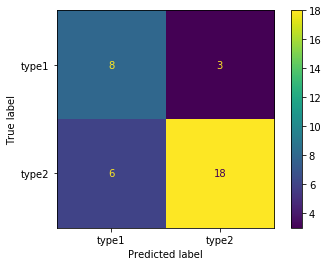

In [ ]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1) 
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

In [ ]:
model.save('type2.h5')